# 개요
* 참여중인 데이터 엔지니어링 스터디에서 배우는 내용 정리
  * 데이터 수집, 정제 : pyspark, airflow
  * 저장 : elasticsearch
  * 시각화 : kibana

# 3주차 과제리뷰

## 정제코드 작성해보기
* jobs
  * main.py
    * Spark initialization + filter(정제) + 저장
    * 공통기능
    * 추후 자동화될 부분 고려되어있는 코드
      ```python
        parser = argparse.ArgumentParser()
        parser.add_argument("--target_date", default=None, help="optional:target date(yyyy-mm-dd)")
        args = parser.parse_args()

        # ...(생략)

        if args.target_date is None: # 정제실패시 다시돌릴 때 편의를 위함
            args.target_date = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
        args.input_path = f"/opt/bitnami/spark/data/{args.target_date}-*.json" # 데이터명이 날짜일 예정
      ```

  * filter.py
    * 정제코드(BaseFilter + TopRepoFilter)
    ```python
    from base import BaseFilter # base.py에서 가져옴

    class TopRepoFilter(BaseFilter):
        def filter(self, df):
            # Top 10 Repo: Push Count
            repo_cnt_df = df.groupBy('repository_id', 'repo_name').pivot('type').count()
            repo_cnt_df.where((F.col('repository_id').isNotNull())) \
                        .orderBy(F.desc('PushEvent')) \
                        .limit(10)
            return repo_cnt_df
    ```

     * 정제코드(BaseFilter + DailyStatFilter)
    ```python
    from base import BaseFilter # base.py에서 가져옴

    class DailyStatFilter(BaseFilter):
        def hit_count(self, df, cond, col_name):
            # is_cond 컬럼을 만든 후, 
            # F.col('type') == 'PushEvent' 와 같은 조건을 F.when(cond, 1)에 넣어 값이 조건에 맞으면(PushEvent) 1, 아니면(otherwise) 0
            # .agg(F.sum('is_cond').alias(col_name) 으로 합산 후 alias지정
            return df.withColumn('is_cond', F.when(cond, 1).otherwise(0)).agg(F.sum('is_cond').alias(col_name))
            

        def filter(self, df):
            # daily stats
            ## 유니크한 유저  :  d_user_count  | 1000
            stat_df = df.agg(F.countDistinct('user_name').alias('d_user_count'))
            ## d_repo_count | 500 데이터프레임을 만든 후, crossjoin으로 합침  :  d_user_count, d_repo_count | 1000, 500
            stat_df = stat_df.crossJoin(df.agg(F.countDistinct('repository_id').alias('d_repo_count')))

            # push counts
            ## where절로 숫자를 구한 후 데이터프레임 생성작업이 필요없도록, hit_count함수로 구현
            ## 
            push_cnt_df = self.hit_count(df, F.col('type') == 'PushEvent', 'push_count')
            push_cnt_df = push_cnt_df.cache() # 캐시를 호출하여 최적화에 도움
            stat_df = stat_df.crossJoin(push_cnt_df)

            pr_cnt_df = self.hit_count(df, F.col('type') == 'PullRequestEvent', 'pr_count')
            pr_cnt_df = pr_cnt_df.cache() # 캐시를 호출하여 최적화에 도움
            stat_df = stat_df.crossJoin(pr_cnt_df)

            fork_cnt_df = self.hit_count(df, F.col('type') == 'ForkEvent', 'fork_count')
            fork_cnt_df = fork_cnt_df.cache() # 캐시를 호출하여 최적화에 도움
            stat_df = stat_df.crossJoin(fork_cnt_df)

            commit_comment_cnt_df = self.hit_count(df, F.col('type') == 'CommitCommentEvent', 'commit_comment_count')
            commit_comment_cnt_df = commit_comment_cnt_df.cache()
            stat_df = stat_df.crossJoin(commit_comment_cnt_df)

            stat_df.show(10, False)
            return stat_df
    ```

  * base.py
    * executor세팅 관련코드
    ```python
      def read_input(spark, input_path):
        def _input_exists(input_path):
            return glob.glob(input_path)

        if _input_exists(input_path):
            df = spark.read.json(input_path)
            df.printSchema()

            # 파티션의 수가 EXECUTOR보다 적으면 리파티션 (노는 EXECUTOR방지)
            max_executor_num = 3
            if df.rdd.getNumPartitions() < max_executor_num:
                df = df.repartition(max_executor_num)
            return df
        else:
            return None
    ```

    * 메타정보 추가코드
    ```python
    def df_with_meta(df, datetime):
        df = df.withColumn("@timestamp", F.lit(datetime)) 
        return df
    ```

## spark-submit

* 참고사항
  * memory옵션(driver, executor), num-executors, executor-cores를 만져보기
  * gh archive데이터를 기준으로 메모리 3기가 정도가 원활해보임
```
spark-submit \
  --name main.py \
  --master spark://spark-master:7077 \
  --jars "/opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar" \
  --conf spark.dynamicAllocation.enabled=true \
  --conf spark.dynamicAllocation.executorIdleTimeout=2m \
  --conf spark.dynamicAllocation.minExecutors=1 \
  --conf spark.dynamicAllocation.maxExecutors=3 \
  --conf spark.dynamicAllocation.initialExecutors=1 \
  --conf spark.memory.offHeap.enabled=true \
  --conf spark.memory.offHeap.size=2G \
  --conf spark.shuffle.service.enabled=true \
  --conf spark.executor.memory=2G \
  --conf spark.driver.memory=2G \
  --conf spark.driver.maxResultSize=0 \
  --num-executors 2 \
  --executor-cores 1 \
  ${SCRIPT}
```

# 4주차 수업정리

## Elasticsearch

* Elasticsearch은 검색엔진인데 왜 저장용도로 사용하는가
  * ELK스택 : Elasticsearch + Logstash + Kibana를 같이 사용. 로그데이터 관리/모니터링 등에 많이 사용(스타트업부터~대기업까지도)
  * 검색엔진이 아닌 ELK스택과 같은 활용으로 이해
  * 키바나와 같이 사용할 수 있는 매력(편리함)
    * 데이터의 저장/커넥션/export 등의 과정없이, ES의 호스트네임 입력만으로 쉽게 연동 가능  
<br>

* Elasticsearch
  * distributed, RESTful search and analytics engine
    * RESTful : REST API형태로 호출해서 검색가능(서버에 쿼리를 날리면 검색이 가능)
  * Apache Lucene을 기반으로 만든 분산 검색 엔진
  * Analyzer가 내장되어있어 document를 저장하게되면, 검색되도록 해줌
<br>


* Elasticsearch 특징(Characteristics)
  * transaction, join 지원되지 않음
    * join을 사용해야하는 경우는 ES를 쓰지 않도록 해야 함
  * (검색을 위한)색인작업 시간이 필요
    * 색인을 위한 Scoring 알고리즘(제일 적합한 문서임을 점수를 매김) : TF-IDF→BM25로 변경됨
      * BM25는 대기업 검색엔진에도 들어있음
  * 버전업이 빠르고/잦고/많음. 이에 따라 (버전별) UI나 API차이가 클 수 있음
<br>

* Elasticsearch 구조 (Structure)
  * document : 하나의 기본 구조. json 형태로된 문서
  * field : document의 필드 (jon의 필드, dataframe에서의 컬럼과 같음)
  * index : document가 모인 단위, 여러 노드에 분산 저장됨(분산 검색엔진이므로)
    * RDBMS의 index와는 다른 역할. index를 만들어 빠르게 쿼리를 가능하게 하지 않음
  * _id : index내 문서에 부여된 unique id (`ES가 unique함을 보장하지는 않으며` 사용자의 책임 하에 사용)
    * 다른 index의 _id라면 같을 수 있음
    * 같은 index 내의 문서라고, 다른 shard에 있어 동일 _id 를 가질 가능성 있음
      * 강제하고, 체크하고 있지 않기 때문
<br>

* Shard
  * Primay와 Replica가 있음. 아래 그림기준 같은 색 칠해진 것들이 같은 Shard
  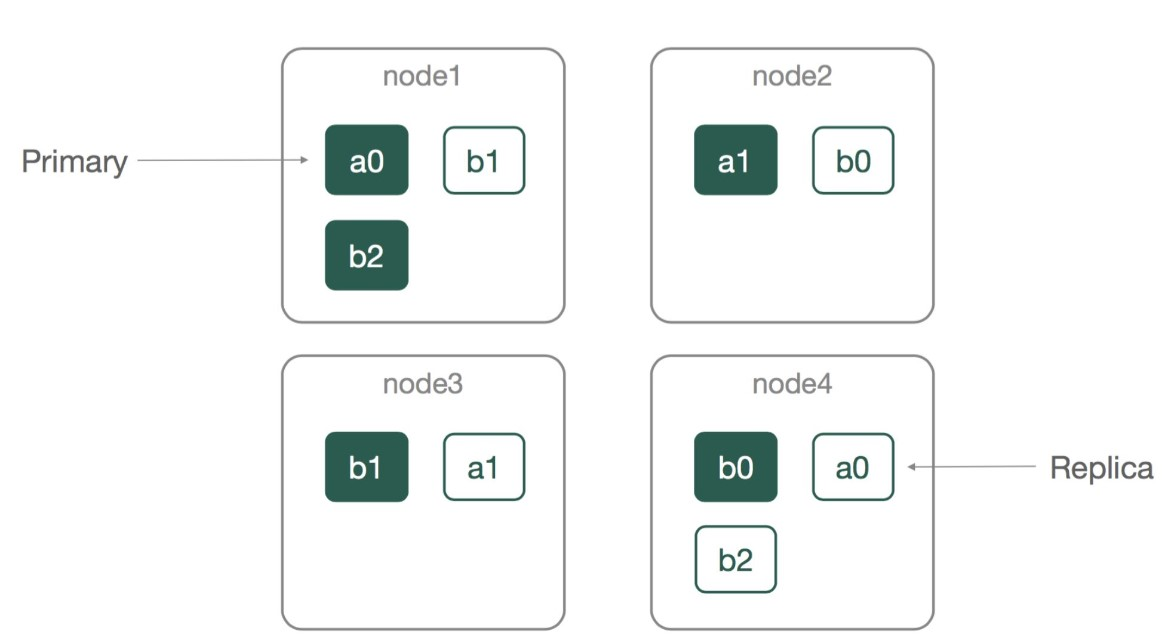
<br>

* Search과정(저장~쿼리~결과도출까지 ES내부적으로 일어나는 일) 및 용어
  * document를 분석해서 Lucene(루신)이 inverted index(역색인)를 생성
    * 아파치 루신이 (메모리에서) 역색인을 생성
  * document의 insert/update/delete 변경을 메모리에 들고 있다가 주기적으로(batch단위로) disk에 flush 
    * refresh: 디스크에 내려 검색가능해짐
  * disk에 flush(들어간)된 segment들이 중간중간 적절히 segment merge됨
    * segment: 디스크에 기록된 파일들의 단위
  * (여러 segment가 모인) lucene index
    * 루신엔진의 역할은 모인 segment에서 결과를 검색하여 결과를 줌(Lucene은 index 내에서만 검색 가능)
    * 루신엔진이 준 결과를 ES가 모아 merge에서 리턴함
  * shard(lucene index를 모은[wrapping] 단위)
  * eleasticsearch index : 여러 shard 가 모인 단위.
    * ES에서 높은 highlevel에서 부르는 index
    * ES검색을 하면 각 shard에 명령이 내려가 내부에서 검색한 후, 결과를 merge해서 줌
  * commit : fsync()를 통해, 커널시스템 캐시내용 ↔ 실제 디스크내용의 sync를 맞춤 (⇒ 비싼 작업)
    * 커널시스템 캐시내용 : lucene flush 시킨 것
    * commit주기는 옵션으로 지정 가능
  * Elasticsearch의 flush는 내부적으로 Lucene commit을 수행
    * flush가 일어나면 commit을 수행 (디스크를 내리고 싱크를 맞추는 작업의 반복)
  * translog : commit 되기 전의 작업 기록 (로딩실패 등의 경우 shard recovery 에 이용)
    * commit되었다면 fail해도 내용을 잃어버리지 않겠지만, commit되지 않은 기록은 translog로 보존
  * 참조 이미지<br>
    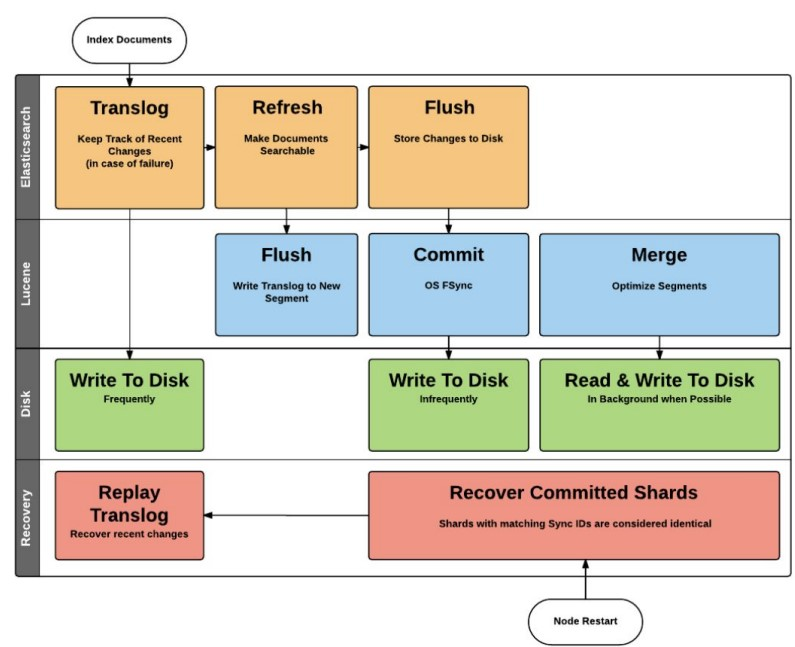
<br>

* nodes
  * master node: 데이터의 저장보다는 관리의 역할
    * 클러스터를 관리 - 인덱스 생성이나 삭제, 샤드 할당 
    * master-eligible node : master node 가 될 수 있는 후보들. 지정할 수도 있음
      * master-eligible node끼리 voting해서 master node를 뽑게 됨
  * data node: 데이터가 저장되는 노드. CRUD/Search/Aggregation 등이 일어남
  * ingest node: 색인 전처리(ingest pipeline) 수행
  * coordinating node: role이 전부 지정되지 않은 노드(master/data/ingest 모두 아님)
    * 클라이언트 요청만 처리(coordinating만 함). data nodes에 요청을 포워딩하고 결과를 모아서 클라이언트에게 응답 
  * 기본적으로는 모든 노드가 coordinating 역할을 수행
<br>

* ES Install
  * 설치링크 : https://www.elastic.co/kr/downloads/elasticsearch
  * 최신 ES에는 이미 JDK 내장되어 있음
    * ES_JAVA_HOME 옵션을 지정해서 JDK 변경 가능
<br>
  
* ES 실습환경 설정관련 유의사항(사용중인 docker-compose.yml 수정하는 경우)
  * ES의 버전에 맞춰 Kibana의 버전도 맞추어야 함 (같이 사용하려면)
    ```python
        es:
          image: docker.elastic.co/elasticsearch/elasticsearch:8.4.3 # Kibana연동시 이 버전과 맞춰야 함
          networks:
            - default-network
          environment:
            - node.name=es # 노드이름 설정
            - discovery.type=single-node
            - discovery.seed_hosts=es
            - xpack.security.enabled=false
            - xpack.security.enrollment.enabled=false
            - xpack.security.http.ssl.enabled=false
            - xpack.security.transport.ssl.enabled=false
            - cluster.routing.allocation.disk.threshold_enabled=false
            - ELASTIC_PASSWORD=password
          mem_limit: 1073741824 # 환경에 따라 미지원될 수 있음. 삭제해도 무방
          ulimits:
            memlock:
              soft: -1
              hard: -1
          volumes:
            - ./es-data:/usr/share/es/data # es-data폴더로 지정. 로그작성 등에 사용
          ports:
            - 9200:9200
    ```
  * localhost:9200/?query='키워드'와 같은 느낌으로도 실행가능 (REST API이므로)

## Elasticsearch index

* Elasticsearch index
  * Lucene index와 elasticsearch index는 다름을 참고

* Settings
  * number_of_replicas(동적으로 변경 가능) : primary shard 1개 당 replica shard 개수
  * number_of_shard(**reindex없이 변경 불가**) : index 에 지정된 shards 의 수
    * RDBMS의 index와 달리 어렵고 비용이 많이 드는 작업(Scoring알고리즘 등의 재실행)
    * reindex는 서비스가 돌고 있으면 서비스를 내려야 하는 등 하기 어려움
<br>

* set index
  * PUT <실제index-name> : index 만들기
  * GET <실제index-name> : 만든 index확인하기
  * refresh_interval : 검색대상이 되도록 얼마나 자주 refresh(새로운 데이터의 색인 생성에 대한 주기)
    * index.search.idle.after (default는 30)
      * -1일 경우 refresh하지 않음 (현재 실습처럼 검색하지 않고 쓰는 경우에 사용가능)
<br>

* field type
  * field의 타입
    * simple(기본) 타입 : text, keyword, date, long, double, boolean, ip
      * text vs keyword
        * text : analyzer가 적용된 후 색인
          * analyzer가 각 단어를 분석했기 때문에 full-text search 가능
        * keyword : analyzer가 적용되지 않고 색인
          * analyzer가 토큰별 분석을 하지 않아 전체문장 일치해야 검색 가능(즉 search용도가 아님)
          * search대상이 아닌 sorting/aggregation대상인 경우 많이 사용
          * (analyzer가 적용되지 않으므로) text보다 빠르다
    * 계층 구조있는 타입 : object, nested
    * 그 외 타입 : geo_point, geo_shape, completion
  * **한번 지정되면 reindex하지 않으면 변경 불가**. (설계시 신중하게)
<br>

* index mapping
  * dynamic mapping : 새로운 field name으로 데이터가 들어오면 적당한 타입을 부여
  * explicit mapping : 명시적으로 mapping을 사전에 지정 (**실제 서비스 등에서 주로 사용**)
<br>

* custom analyzer
  * 사용자가 원하는 analyzer(서드파티 포함) 지정 가능
  * html_strip, standard, lowercase, stop-token(욕설 등 특정 토큰 색인X) 등
  * 여러 analyzer 등을 완료하면 색인이 가능해짐
<br>

* multifields
  * 한 필드의 데이터를 여러 설정으로 색인 가능
    * (서비스 요구사항이 fix되어)매핑이 지정되었는데 추가 요구사항이 있는 경우, 반영하기 위해 사용
    * reindex는 비용이 많이 듦
<br>

* 옵션 index:false
  * 해당 필드 역색인을 만들지 여부(default:true)
    * 주의 : index를 만들지 않으므로 검색대상이 되지 않음
  * ES 8.1 부터 필드가 doc_values를 사용한 경우는 index없이도 검색 가능(검색 성능은 떨어짐)
  * 역색인을 생성하지 않을 뿐 정렬이나 집계 가능
    * text와 annotated_text 타입을 제외하고 지원
    * sorting, aggregations, script 이 필요없으면 disable 가능
<br>

* 옵션 enabled:false(object 필드에 적용)
  * false지정시, 파싱도 수행하지 않음
  * _source에 들어가지만 검색/저장되지 않음
    * 데이터 명세상 잘 오고 있는지 확인하는 정도로만 갖고 싶을 때(_source에서 확인만)
    * API로 받은 데이터를 모두 사용하지 않고, 특정 데이터만 확인하고 싶을 때
<br>

* fielddata(**잘쓰지 않음**)
  * text 필드에 대해 sorting, aggregations, 혹은 script 작업을 수행해야할 때 사용
  * **text 필드를 sorting하고 싶을때** fielddata:enable로 적용
    * text필드이므로 analyzer 적용되고 색인이 생성됨 (예를 들면 문장단위의 sorting 실행됨)
    * sorting을 하려면 메모리에 올려야 하므로, **heap메모리 사용이 순간적으로 커진다**
  * 기본적으로 disable
<br>

* analyzer
  * 원하는 **여러 필터**를 순서대로 적용 가능
  * 적용순서 : character filters → tokenizer → token filters
  * 종류 : HTML Strip Character Filter, Mapping Character Filter, Pattern Replace Character Filter
<br>

* tokenizer
  * character stream에서 stream of tokens로 바꿈
  * 1개의 tokenizer만 지정 가능 (토큰 생성방법에 따라 후속이 많이 달라지므로)
  * 기본제공 토크나이저 중 한글전용 토크나이저는 없음 (별도 형태소 분석기 등을 붙여 사용해야 함)
  * 종류 : standard tokenizer, etter tokenizer, whitespace tokenizer, ngram tokenizer 등
    * ngram tokenizer예시) min 2, max 3: hello → he, hel, el, ell, ll, llo
<br>

* token filter
  * token stream에서 token을 추가/변경/삭제
  * 0개 이상(미지정 가능)
  * 종류 : lowercase/uppercase, stop words, synonym, pattern_replace, stemmer(어간 추출, 한글불가), trim, truncate
<br>

* normalizer
  * keyword 필드(text필드와 달리 analyzer미적용)에만 적용. analyzer와 비슷
  * analyzer는 stream of charactor를 stream of token으로 만들어줌
    * character filters → tokenizer → token filters
  * normalizer는 단일 토큰만 생성.
    * character filters, token filters를 적용가능하게 해줌
      * 예를 들어, 특정 문자만 지우는 등의 기능으로 사용
<br>

* _routing
  * document가 어떤 shard에 배정될지 지정
  * shard number를 결정할 때 보통 hash알고리즘으로 되어있음
    * shard_num = hash(_routing) % num_primary_shards
  * 기본값으로 _id를 사용(유니크값이므로 각 데이터별로 어느 shard에 넣을지 결정하기에 용이)
  * 색인시에 routing지정했다면 update, delete, get, search 시에도 지정해야 함
    * update 할 때 등도 shard를 찾아 갈 수 있도록 지정해야 함

## Query(ES에서 쿼리하는법)

* Elasticsearch Query
  * get/put/delete 등 Restful API같은 구조
<br>

* get API
  * _doc
    * GET <index>/_doc/<_id>
      * 그냥 _id만 넣으면 어느 index에서 찾아야할지 ES가 판단 불가
      * translog에만 기록이 된 것도 조회가 가능하다(**get은 검색은 아니라는 뜻**)
    * HEAD <index>/_doc/<_id>
      * 존재여부를 bool로 반환
  * _source/ (object필드에 enabled:false 적용한 경우 rawdata저장되는 곳)
    * GET <index>/_source/<_id>
    * HEAD <index>/_source/<_id>
      * 존재여부 확인 가능
<br>

* _source 추가 설명
  * 원본 JSON document body를 저장
  * 색인되지 않으므로 검색대상이 아닌 원본 데이터임
  * 주의사항 : `_source: disable` 할 경우 update, reindex 등을 사용할 수 없다
    * 다른 데이터는 analyzer를 통과한(색인된) 데이터이므로, 재색인할 때는 활용불가하며 원본 있어야함
    * 원본으로 _source에 넣어두므로, disable해두면 reindex나 update를 통한 버전업 불가
<br>

* delete API
  * DELETE <index>/_doc/<_id>
    * 삭제flag만 올려두고, 실제 삭제는 Licene segment의 주기적으로 merge될 때 진행됨
    * 내부적으로는 최근 삭제된 문서를 일정기간 보존(shard복구시 삭제 작업을 재처리하기 위함)
<br>

* update API
  * POST <index>/_update/<_id>
    * 일부 필드 업데이트(doc_as_upsert가능)
    * detect_noop: 실질적으로 어떠한 값도 변경하지 않을 경우 수행 X
      * 아무값 변경이 없는데 POST명령이 들어간 경우, 업데이트를 수행하지 않도록 하는 기능
<br>

* multiget API
  *  GET /_mget
    {
      “docs”: [ ]
    }
<br>

* bulk API
  * POST /_bulk
    * index, create, delete, update를 한번에 모아보낼 수 있음
    * \n 으로 데이터 구분
    * Content-Type: application/x-ndjson, 마지막 라인 \n 으로 종결
    * **대량 색인 작업 시에 필수로 사용(처음 ES구축시 대량색인해야할 때)**
    * 실제 적용 순서가 보장되지 않음 (여러 bulk 작업 간의 순서 보장 X)
      * 분산 작업이므로(여러 노드가 작업하므로)
    * 한 bulk request 안의 같은 _index + _id 조합은 순서 보장
<br>

* Delete by query 
  * 조건에 맞는 document 삭제
  * 주의사항
    * 쿼리 조건에 맞는 document가 여러개일 경우, 삭제하려던 것이 삭제되어있거나 업데이터 되어 쿼리에 맞지 않을 수 있음
      * index 스냅샷을 찍고 스냅샷을 기준으로 작업 진행
      * 스냅샷 이후 변경이 확인되면, 삭제 실패로 끝남
    * `wait_for_completion: false` : async 작업 가능
      * delete될 쿼리를 날려두고 다른 작업ㅇ르 할 수 있음
    * 작업 결과가 .tasks index에 document 로 남음
      * Delete by query가 잘못되었을 때 복구할 수 있도록
  * update by query도 있음
<br>

* **search** (중요)
  * `GET <index>/_search` or `POST <index>/_search`
  * 특징
    * 색인 생성한 것에 대해 맞는 문서를 리턴(scoring순서에 맞게 나옴)
    * (index 여러 곳에서 검색하기 위해)index는 ,로 구분하여 지정 가능
    * index 이름에 wildcard * 지정 가능
    * query string 인자를 이용하는 검색도 존재
      * ex) GET /test/_search?q=fieldName:queryText
  * match_all(모두 만족) / match(하나의 필드가 만족)
    ```
      {“query”: {
          “match_all”: {}
          “match”: {       “mytext”: “Hello, World!”     }
        } }
    ```
  * term / terms
    * query string 을 analyze하지 않음(exact term을 포함한 문서를 찾음)
    * keyword 필드의 경우 normalizer 가 적용되었으면 쿼리에도 적용
    * terms: 여러 query string (조건) 에 의해 검색
<br>

* prefix query
  * 필드가 특정한 prefix로 시작하는 document 검색
  * 명시적 매핑(explicit mapping)시 index_prefixes옵션을 미리 준 경우,
    * 속도가 높일 수 있으나(analyzer와 관계없이), 그렇지 않았다면 expensive query
      * 많은 DB에서는 사실상 prefix query는 expensive query
  * ES는 비싼 쿼리를 가능하게할지 말지도 옵션 지정 가능
    * `search.allow_expensive_queries: false`라면 expensive query불가
<br>

* range/exists
  * range: 필드가 특정 range 이내의 값인 document
    * gt(greater than), gte, lt, lte로 range를 지정
    * date field 에 대해서도 지원
    * text / keyword 필드에 대한 range query는 expensive query
      * `search.allow_expensive_queries: false`라면 사용불가
  * exists: 필드에 값이 색인되어 있는 document
    * empty string 도 값이 있는 것으로 판단
    * JSON 이 null 이거나 [], [null, null] 등일 경우 값이 없는 것으로 판단
    * mapping 에 index: false 여서 색인되지 않은 경우에도 값이 없는 것으로 판단bool query
<br>

* bool query(여러 쿼리를 조합하는 쿼리)
  * must: 지정된 모든 쿼리 조건을 만족해야 함
  * must_not: 지정된 모든 쿼리 조건을 만족하지 않아야 함
  * **should**: 지정된 쿼리 중 적어도 minimum_should_match 개수 만큼 만족해야 함
    * filter는 모두 만족해야 함
      * filter : 쿼리 외의 true/false로 답이 나오는 것들
        * query는 relevance score를 계산(리턴값이 score)해 얼마나 문서와 잘 매칭되는지 판단
        * filter와 query 중 우선순위는 없음
          * should query(bool)라면, filter는 만족하는 query중에서 minimum_should_match를 count
<br>

* sort
  * 필드를 지정해서 검색 결과를 정렬(보통 score는 계산하지 않고 정렬만 함)
  * 정렬 중에는 필드 값이 메모리에 올라감
    * text 타입은 일반적으로 정렬 대상이 될 수 없음 (성능이슈, 비싼작업)
<br>

* from / size
  * 기초적인 pagination. 
  * 1만개를 초과한 document를 pagination할 수 없으며, 이로 인해 잘 사용되지 않음
    * index.max_result_window settings로 기본값이 1만개로 되어있음
  * 메모리 & 시간이 from + size 의 값에 비례
<br>

* scroll / search_after
  * from, size 대신 사용되는 pagination방법
  * scroll: search context를 유지하며 대량 데이터를 처리
    * 검색이 수행된 그 상태를 스냅샷처럼 찍어 검색 결과를 스크롤링
    * (스냅샷 쓰므로)스크롤링 도중 변화되는 문서 내용은 반영되지 않음
    * 옵션
      * size: 배치에 반환할 문서의 수
      * _scroll_id: 다음 배치의 검색 값 받을 수 있음
    * scroll 인자로 넘겨준 시간만큼 search context를 유지
    * 기준값이 동일한 document 사이에서는 일관된 순서를 보장하지는 않음(sort되어 나오지 않음)
  * **search_after(제일 많이 사용)**: 결과 문서 중 가장 마지막 문서의 sort 기준값을 사용
    * _id 필드는 doc value가 disabled되어 있기 때문에 이를 기준으로 하는 정렬은 많은 메모리를 사용
      * _id필드로 정렬하지는 않는다는 뜻
    * scroll과 다른점 : 실시간 변경 데이터 반영 가능

## Optimization

* reindex
  * 비싼 작업
  * 원본 index내 문서의 _source를 읽어서 대상 index에 새로 색인
  * query를 지정하여 일부 문서만 reindex 가능
  * script 이용하여 throttling, slicing, 비동기 작업 가능
  * 다른 Elasticsearch 클러스터에서 데이터를 가져와 reindex 가능
    * 다른 Elasticsearch를 연결하려면 elasticsearch.yml에 reindex.remote.whitelist: "host:XXXX" 추가
    ```
    POST _reindex
    {“source”: …
       “dest”: …}
    ```
<br>

* Index life cycle
  * 종류
    * hot: 현재 업데이트가 수행되고 있고 읽기 작업도 가장 많은 상태
    * warm: 인덱스에 더 이상 업데이트가 수행되지는 않지만 읽기 작업은 들어오는 상태
    * cold: 인덱스에 더 이상 업데이트가 수행되지 않고 읽기 작업도 가끔씩만 들어오는 상태. 
      * 검색은 되어야 하나 속도가 느려도 괜찮은 상황.
    * frozen: 인덱스에 더 이상 업데이트가 수행 되지 않고 읽기 작업도 거의 들어오지 않는 상태. 
      * 검색은 되어야 하나 속도가 상당히 느려도 괜찮은 상황.
    * delete : 인덱스가 더 이상 필요없고 삭제되어도 무방한 상태
  * index가 어느 cycle에 있는지 보면서 자원을 분배
    * 이에 따라 검색속도 차이가 많이 남
    * 검색이 느리다면 'cold'로 간 것은 아닌지 유추
<br>

* Index strategies
  * time series로 만들기 (보통 추천)
    * (RDBMS처럼)데이터 종류별로 만드는 것이 아닌, 2024.01, 2024.02 등
    * 보통은 최근 데이터로 분석하는 경우 많음
    * 검색 범위를 좁히기 + index life cycle전략짜기 에 용이함
    * 오래된 데이터 삭제에 편리
  * 데이터가 커질 경우 index mapping 직접 만들기
  * index template 활용하기 (비슷한 index mapping 사용하는 경우)
  * routing활용하기(어떤 shard에 데이터를 저장할지 지정)
    * 성능 향상
    * index mappings _routing meta field 에 required: true 옵션을 부여해 강제할 수 있다
  * field type은 기본적으로 변경 불가능함을 염두에 두기
    * 같은 필드의 type 이 계속 변경될 수 있다면 ES특성상 ES가 적합하지 않음
    * 해당 데이터가 들어와야 한다면 `enable: false`로 색인포기하고 에러발생하지 않게 할 수 있음
  * 운영도중 analyze 변경 필요성이 있다면, multi field를 고려한다
<br>

* Shard Strategies
  * shard의 개수
    * shard 갯수를 노드 수의 n배로 둘 필요는 없음
      * hot/warm 등 index에 따라 리소스가 분배되므로, 성능향상에 꼭 도움이 되지 않음
        * 활용중인 index가 많은 경우, 단일 index작업에 모든 노드가 참여하지 않음(고르게 분배되지 않음)
    * 추후 추가 서버가 투입될 가능성이 있음